In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.metrics import confusion_matrix, accuracy_score
import xgboost as xgb

# from imblearn.over_sampling import SMOTE, RandomOverSampler

# Train model

In [17]:
GOAL = ['target']
FEATURES = ['CreditScore', 'Geography', 'Age', 'Tenure',
            'Balance', 'NumOfProducts', 'HasCrCard',
            'IsActiveMember', 'EstimatedSalary'
           ]
IGNORED_FEATURES = [] # a placeholder for irrelevant features
TRAIN_FEATURES = list(set([c for c in FEATURES if c not in IGNORED_FEATURES]))
NUMERICAL_FEATURES = ['CreditScore', 'Age', 'Tenure', 'Balance',
                      'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                      'EstimatedSalary'] # requires imputation
CATEGORICAL_FEATURES = ['Geography', 'Gender'] # requires label encoding followed by imputation

over_sampling = False

In [18]:
def run_load_data():
    print ('load_data - START')
    df = pd.read_csv('../../data/data_binary_classification_train.csv')
    print ('load_data - END')
    return df

In [19]:
def run_train_test_split(df):
    print ('train_test_split - START')
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    print ('train_test_split - END')
    return train_df, test_df

In [20]:
def run_pre_processing(train_df, test_df):
    print ('pre_processing - START')  
    # Fill NULL with Mean / Median / -1
    for f in NUMERICAL_FEATURES:
        # Imputation
        imp = Imputer(missing_values='NaN', strategy='median',axis=0, copy=False)
        train_df[f] = imp.fit_transform(train_df[f].values.reshape(-1,1))
        test_df[f] = imp.fit_transform(test_df[f].values.reshape(-1,1))
    
    # Pre-processing non-numeric values using numeric encoding, followed by imputation of most_frequent value
    # Why use numeric encoding over one hot encoding:
    # https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931
    # Encode using .cat.codes or LabelEncoder:
    # http://pbpython.com/categorical-encoding.html
    for f in CATEGORICAL_FEATURES:
        # Numerical Encoding
        train_df[f] = train_df[f].astype('category').cat.codes
        test_df[f] = test_df[f].astype('category').cat.codes
#         lbl = LabelEncoder()
#         train_df[f] = lbl.fit_transform(train_df[f].reshape(-1,1))
#         test_df[f] = lbl.fit_transform(test_df[f].reshape(-1,1))
        # Imputation
        imp = Imputer(missing_values='NaN', strategy='most_frequent',axis=0, copy=False)
        train_df[f] = imp.fit_transform(train_df[f].values.reshape(-1,1))
        test_df[f] = imp.fit_transform(test_df[f].values.reshape(-1,1))
    print ('pre_processing - END') 
    return train_df, test_df

In [21]:
def run_x_y_split(train_df, test_df):
    print ('x_y_split - START')
    X_train = train_df[TRAIN_FEATURES]
    y_train = train_df[GOAL]
    X_test = test_df[TRAIN_FEATURES]
    y_test = test_df[GOAL]
    print ('x_y_split - END')
    return X_train, y_train, X_test, y_test

In [22]:
def run_over_sampling(X_train, y_train):
    print ('over_sampling - START')
#     TODO: Figure how to oversample using SMOTE 
#     X_train, y_train = SMOTE().fit_sample(X_train, y_train)
#     X_train, y_train = RandomOverSampler().fit_sample(X_train, y_train)
    print ('over_sampling - END')
    return X_train, y_train

In [23]:
def run_grid_search(X_train, y_train):
    print ('grid_search - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    gbm_param_grid = {
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 4],
        'n_estimators': [500, 750],
        'subsample': [0.5, 0.75],
        'colsample_bytree': [0.5, 0.75]
    }
    
    gbm = xgb.XGBClassifier()
    
    # Perform grid search
    grid = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                            scoring='roc_auc', cv=5, verbose=1)
    grid.fit(X_train, y_train.values.ravel()) # Using values.ravel() to change to 1D array - https://stackoverflow.com/questions/42928855/gridsearchcv-error-too-many-indices-in-the-array

    # Print the best parameters & metric
    print("Best parameters found: ", grid.best_params_)
    print("Best AUC found: ", grid.best_score_)
    
    best_learning_rate = grid.best_params_["learning_rate"]
    best_max_depth = grid.best_params_["max_depth"]
    best_n_estimators = grid.best_params_["n_estimators"]    
    best_sub_sample = grid.best_params_["subsample"]   
    best_colsample_bytree = grid.best_params_["colsample_bytree"]  
    
    print ('grid_search - END')    
    return best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree

In [24]:
def run_cross_validation(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree):
    print ('cross_validation - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    params = {"objective":"binary:logistic", 
              "learning_rate":best_learning_rate,
              "max_depth":best_max_depth,
              "n_estimators":best_n_estimators,
              "subsample":best_sub_sample,
              "colsample_bytree":best_colsample_bytree
             }
    
    print(dmatrix)
    
    cv_results = xgb.cv(dtrain=dmatrix,
                        params=params,
                        nfold=5,
                        stratified=True,
                        num_boost_round=10,
                        metrics="auc",
                        as_pandas=True,
                        seed=123)
    print(cv_results)
    model_evaluation_metric = cv_results["test-auc-mean"].iloc[-1]
    print "cross-validation model accuracy on train dataset: ", model_evaluation_metric
    # TODO: Obtain and print auc standard deviation to identify overfitting
    print ('cross_validation - END')    

In [25]:
def run_train_model(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree):
    print ('train_model - START')    
    model = xgb.XGBClassifier(objective='binary:logistic',
                              learning_rate=best_learning_rate,
                              max_depth=best_max_depth,
                              n_estimators=best_n_estimators,
                              subsample=best_sub_sample,
                              colsample_bytree=best_colsample_bytree,
                              silent=True,
                              seed=123
                             )
    
    model.fit(X_train, y_train)
    print ('train_model - END')   
    return model

In [26]:
def run_prediction(model, X_test):
    print ('run_prediction - START')  
    prediction = model.predict(data=X_test)
    print ('run_prediction - END')  
    return prediction

In [27]:
def run_model_evaluation_on_test(prediction, y_test):
    print ('model_evaluation_on_test - START')
    
    cm = confusion_matrix(y_test, prediction)
    print "model confusion matrix: ", cm
    
    prediction = pd.DataFrame(data = prediction, index=y_test.index, columns = ['target'])
    model_evaluation_metric = accuracy_score(y_test, prediction)
    print "model accuracy on test dataset: ", model_evaluation_metric

    print ('model_evaluation_on_test - END')

In [28]:
def run_save_model(model):
    print ('save_model - START')
    pickle.dump(model, open("trained_models/xgboost_binary_classification", "wb"))
    print ('save_model - END')

In [29]:
def run_feature_importance(model):
    print ('feature_importance - START') 
    xgb.plot_importance(booster=model)
    plt.title('Feature Importance')
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    print ('feature_importance - END')   

load_data - START
load_data - END
train_test_split - START
train_test_split - END
pre_processing - START


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

pre_processing - END
x_y_split - START
x_y_split - END
grid_search - START
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.2min finished


('Best parameters found: ', {'n_estimators': 500, 'subsample': 0.75, 'learning_rate': 0.05, 'colsample_bytree': 0.75, 'max_depth': 3})
('Best AUC found: ', 0.8558362585474242)
grid_search - END
train_model - START


/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train_model - END
run_prediction - START
run_prediction - END
model_evaluation_on_test - START
model confusion matrix:  [[1543   64]
 [ 211  182]]
model accuracy on test dataset:  0.8625
model_evaluation_on_test - END
save_model - START
save_model - END
feature_importance - START


/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


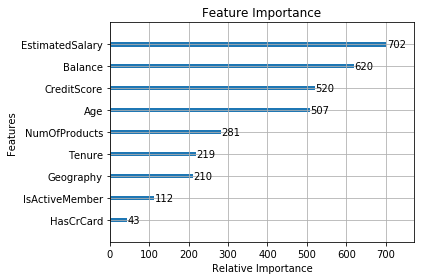

feature_importance - END
('elapsed_time (in seconds): ', 196.75695300102234)


In [30]:
def xgboost_binary_classification_train():
    start_time = time.time()
    df = run_load_data()
    train_df, test_df = run_train_test_split(df) # Don't have to run this if you given data is already splitted into train & test
    train_df, test_df = run_pre_processing(train_df, test_df)
    X_train, y_train, X_test, y_test = run_x_y_split(train_df, test_df)
    if over_sampling:
        X_train, y_train = run_over_sampling(X_train, y_train)
    best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree = run_grid_search(X_train, y_train)
# To check accuracy, run either Grid Search or Cross Validation as Cross Validation is already embedded in Grid Search
#     run_cross_validation(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree)
    model = run_train_model(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree)
    prediction = run_prediction(model, X_test)
    run_model_evaluation_on_test(prediction, y_test)
    run_save_model(model)
    run_feature_importance(model)
    print('elapsed_time (in seconds): ', time.time() - start_time)
xgboost_binary_classification_train()

# Predicting outcome using trained model

In [31]:
FEATURES = ['CreditScore', 'Geography', 'Age', 'Tenure',
            'Balance', 'NumOfProducts', 'HasCrCard',
            'IsActiveMember', 'EstimatedSalary'
           ]
IGNORED_FEATURES = [] # a placeholder for irrelevant features
TRAIN_FEATURES = list(set([c for c in FEATURES if c not in IGNORED_FEATURES]))
NUMERICAL_FEATURES = ['CreditScore', 'Age', 'Tenure', 'Balance',
                      'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                      'EstimatedSalary'] # requires imputation
CATEGORICAL_FEATURES = ['Geography', 'Gender'] # requires label encoding followed by imputation

over_sampling = False

In [32]:
def run_load_data():
    print ('load_data - START')
    df = pd.read_csv('../../data/data_binary_classification_test.csv')
    print ('load_data - END')
    return df

In [33]:
def run_pre_processing(df):
    print ('pre_processing - START')
    # Extract uuid
    uuid = pd.DataFrame(df.loc[:,'uuid'], columns = ['uuid']) # Extract uuid column
    
    # Fill NULL with Mean / Median / -1
    for f in NUMERICAL_FEATURES:
        # Imputation
        imp = Imputer(missing_values='NaN', strategy='median',axis=0, copy=False)
        df[f] = imp.fit_transform(df[f].values.reshape(-1,1))
    
    # Pre-processing non-numeric values using numeric encoding, followed by imputation of most_frequent value
    # Why use numeric encoding over one hot encoding:
    # https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931
    # Encode using .cat.codes or LabelEncoder:
    # http://pbpython.com/categorical-encoding.html
    for f in CATEGORICAL_FEATURES:
        # Numerical Encoding
        df[f] = df[f].astype('category').cat.codes
#         lbl = LabelEncoder()
#         train_df[f] = lbl.fit_transform(train_df[f].reshape(-1,1))
#         test_df[f] = lbl.fit_transform(test_df[f].reshape(-1,1))
        # Imputation
        imp = Imputer(missing_values='NaN', strategy='most_frequent',axis=0, copy=False)
        df[f] = imp.fit_transform(df[f].values.reshape(-1,1))
    print ('pre_processing - END') 
    return df, uuid

In [34]:
def run_x_split(df):
    print ('x_split - START')  
    X = df[TRAIN_FEATURES]
    print ('x_split - END')  
    return X

In [35]:
def run_load_model():
    print ('load_model - START')  
    model = pickle.load(open("trained_models/xgboost_binary_classification", "rb"))    
    print ('load_model - END')  
    return model

In [36]:
def run_prediction(model, X):
    print ('run_prediction - START')  
    prediction = model.predict(data=X)
    prediction = pd.DataFrame(prediction, columns=['prediction'])
    print ('run_prediction - END')  
    return prediction

In [37]:
def run_save_prediction(uuid, prediction):
    print ('save_prediction - START')
    prediction = pd.concat([uuid, prediction], axis=1)
    prediction.to_csv('output/prediction_xgboost_binary_classification.csv', sep=',', index=False)
    print ('save_prediction - END') 

In [38]:
def xgboost_binary_classification_test():
    start_time = time.time()
    df = run_load_data()
    df, uuid = run_pre_processing(df)
    X = run_x_split(df)
    model = run_load_model()
    prediction = run_prediction(model, X)
    run_save_prediction(uuid, prediction)
    print('elapsed_time (in seconds): ', time.time() - start_time)
xgboost_binary_classification_test()

load_data - START
load_data - END
pre_processing - START
pre_processing - END
x_split - START
x_split - END
load_model - START
load_model - END
run_prediction - START
run_prediction - END
save_prediction - START
save_prediction - END
('elapsed_time (in seconds): ', 0.03888297080993652)


/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
